In [1]:
import contextlib
import ipynb.fs
import os
import matplotlib.pyplot as plt
import math
import pandas as pd
import praat_formants_python as pfp
import wave

from .defs.formant_vowel_prediction import vowel_prediction, vowel_prediction_sd
from .defs.vowel_feedback_function import vowel_feedback
from .defs.extract_formant import extract_formant

from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def uniq(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

Native:
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         2
           9      0.000     0.000     0.000         2
           E      0.000     0.000     0.000        10
           O      0.000     0.000     0.000         3
           a      0.512     0.611     0.557        36
           e      0.500     0.571     0.533        14
           i      1.000     0.200     0.333        10
           o      0.000     0.000     0.000         3
           u      0.000     0.000     0.000         2
           y      0.200     1.000     0.333         1

    accuracy                          0.398        83
   macro avg      0.221     0.238     0.176        83
weighted avg      0.429     0.398     0.376        83

Non-native:
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         5
           9      0.130     0.250     0.171        12
           E      0.000     0.000     0.000        15
    

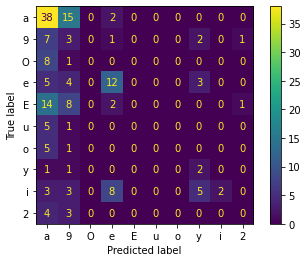

In [17]:
data_folder = Path('../../InterFra/extracted')

vowels_2 = {'oe': '9', 'OE': '2', 'aN': 'ã', 'EN': 'ẽ', 'ON': 'õ'}
vowels = ['a', 'e', 'E', 'i', 'o', 'O', 'u', 'y', '9', '2', 'ã', 'ẽ', 'õ']

y_true_nat = []
y_pred_nat = []
y_true_nnat = []
y_pred_nnat = []

y_true_f = []
y_pred_f = []
y_true_m = []
y_pred_m = []

for file in os.listdir(data_folder):
    path = (data_folder / file).as_posix()
    
    with contextlib.closing(wave.open(path,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    
    try:
        f1, f2, f3, f4 = extract_formant(path, start_time=0, end_time=duration, f0min=math.ceil(3/duration))
    except ZeroDivisionError:
        continue
    
    native = file.startswith('C')
    file2 = file.split('.')[0].split('_')[1:]
    attempted = file2[0].translate({ord(c): None for c in '0123456789'})
    ok = False
    for k, v in vowels_2.items():
        attempted = attempted.replace(k, v)

    for vowel in vowels:
        if vowel in attempted:
            ok = True
            idx = attempted.index(vowel)
            if idx == 1:
                attempted = vowel
                break
            elif idx == 0 and len(attempted) < 3:
                attempted = vowel
                break
            else:
                ok = False

    said = attempted
    if len(file2) > 1:
        said = file2[1]
        for k, v in vowels_2.items():
            said = said.replace(k, v)
            
    ref_data = pd.read_csv('vowel_formants_paillereau.txt', header=0, sep=' ')
    vowel, min_dist = vowel_prediction_sd([f1, f2, f3, f4], ref_data, formants=4)
    said = said.replace('õ', 'O').replace('ã', 'a').replace('ẽ', 'E') # TODO
    attempted = attempted.replace('õ', 'O').replace('ã', 'a').replace('ẽ', 'E') # TODO
    vowel = vowel[1:2]
    
    female = 'CAT' in file or 'ELS' in file
    
    if native:
        y_true_nat.append(said)
        y_pred_nat.append(vowel)
    else:
        y_true_nnat.append(said)
        y_pred_nnat.append(vowel)
        
    if female:
        y_true_f.append(said)
        y_pred_f.append(vowel)
    else:
        y_true_m.append(said)
        y_pred_m.append(vowel)
    
    out = f'[{said}/{attempted}] ' + ' '.join(vowel_feedback(attempted, said)).strip()
    # print(out)

full_true = y_true_m + y_true_f
full_pred = y_pred_m + y_pred_f

print('Native:')
print(classification_report(y_true_nat, y_pred_nat, digits=3, zero_division=0))

print('Non-native:')
print(classification_report(y_true_nnat, y_pred_nnat, digits=3, zero_division=0))

print('Female:')
print(classification_report(y_true_f, y_pred_f, digits=3, zero_division=0))

print('Male:')
print(classification_report(y_true_m, y_pred_m, digits=3, zero_division=0))

print('Overall:')
print(classification_report(y_true_m + y_true_f, y_pred_m + y_pred_f, digits=3, zero_division=0))

labels = uniq(full_true)

cm = confusion_matrix(full_true, full_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

Native:
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         5
           9      0.000     0.000     0.000        10
           E      0.000     0.000     0.000         8
           O      0.000     0.000     0.000         5
           a      0.265     1.000     0.419         9
           e      0.714     0.714     0.714         7
           i      0.000     0.000     0.000         5
           o      0.000     0.000     0.000         5
           u      0.000     0.000     0.000         5
           y      0.333     0.800     0.471         5

    accuracy                          0.281        64
   macro avg      0.131     0.251     0.160        64
weighted avg      0.141     0.281     0.174        64

Non-native:
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         2
           9      0.125     0.167     0.143         6
           E      0.000     0.000     0.000         7
    

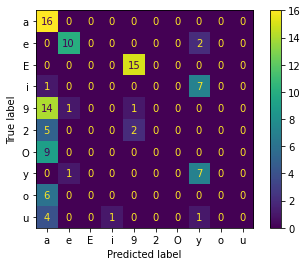

In [24]:
data_folder = Path('../../Classmate corpus/extracted')

vowels_2 = {'oe': '9', 'OE': '2'}
vowels = ['a', 'e', 'E', 'i', 'o', 'O', 'u', 'y', '9', '2']

y_true_nat = []
y_pred_nat = []
y_true_nnat = []
y_pred_nnat = []

y_true_f = []
y_pred_f = []
y_true_m = []
y_pred_m = []

for file in os.listdir(data_folder):
    path = (data_folder / file).as_posix()
    
    with contextlib.closing(wave.open(path,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    
    try:
        f1, f2, f3, f4 = extract_formant(path, start_time=0, end_time=duration, f0min=math.ceil(3/duration))
    except ZeroDivisionError:
        continue
    
    native = any(file.startswith(x) for x in ['Jimmy', 'Kevin', 'Mathilde', 'Maxime', 'Omar'])
    file2 = file.split('.')[0].split('_')[1:]
    attempted = file2[0].translate({ord(c): None for c in '0123456789'})
    ok = False
    for k, v in vowels_2.items():
        attempted = attempted.replace(k, v)

    for vowel in vowels:
        if vowel in attempted:
            ok = True
            idx = attempted.index(vowel)
            if idx == 1:
                attempted = vowel
                break
            elif idx == 0 and len(attempted) < 3:
                attempted = vowel
                break
            else:
                ok = False
    

    said = attempted
    if len(file2) > 1:
        said = file2[1].translate({ord(c): None for c in '0123456789'})
        for k, v in vowels_2.items():
            said = said.replace(k, v)
            
    ref_data = pd.read_csv('vowel_formants_paillereau.txt', header=0, sep=' ')
    vowel, min_dist = vowel_prediction_sd([f1, f2, f3, f4], ref_data, formants=4)
    said = said.replace('õ', 'O').replace('ã', 'a').replace('ẽ', 'E') # TODO
    
    vowel = vowel[1:2]
    
    female = any(file.startswith(x) for x in ['Dimitra', 'Mathilde'])
    
    if native:
        y_true_nat.append(said)
        y_pred_nat.append(vowel)
    else:
        y_true_nnat.append(said)
        y_pred_nnat.append(vowel)
        
    if female:
        y_true_f.append(said)
        y_pred_f.append(vowel)
    else:
        y_true_m.append(said)
        y_pred_m.append(vowel)
    
    out = f'[{said}/{attempted}] ' + ' '.join(vowel_feedback(attempted, said)).strip()
    #print(out)

full_true = y_true_m + y_true_f
full_pred = y_pred_m + y_pred_f

print('Native:')
print(classification_report(y_true_nat, y_pred_nat, digits=3, zero_division=0))

print('Non-native:')
print(classification_report(y_true_nnat, y_pred_nnat, digits=3, zero_division=0))

print('Female:')
print(classification_report(y_true_f, y_pred_f, digits=3, zero_division=0))

print('Male:')
print(classification_report(y_true_m, y_pred_m, digits=3, zero_division=0))

print('Overall:')
print(classification_report(y_true_m + y_true_f, y_pred_m + y_pred_f, digits=3, zero_division=0))

labels = uniq(full_true)

cm = confusion_matrix(full_true, full_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()